In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.base.model import LikelihoodModel
from sklearn import preprocessing

from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import unicodedata
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from linearmodels.iv import absorbing

from linearmodels.datasets import wage_panel
from linearmodels.panel import PanelOLS
from linearmodels.iv.model import (
    COVARIANCE_ESTIMATORS,
    ClusteredCovariance,
    HeteroskedasticCovariance,
    HomoskedasticCovariance,
    KernelCovariance,
)

## references
https://stackoverflow.com/questions/70954911/results-from-python-linearmodels-panelols-and-stata-areg-differ

In [25]:
data.columns

Index(['EU_tld', 'after', 'cookies3', 'cookies_fb', 'date', 'eu_a1', 'eu_a2',
       'eu_a3', 'eu_a4', 'eu_a5', 'eu_alexa', 'eu_audience', 'eu_cb', 'eu_l1',
       'eu_l2', 'eu_l3', 'eu_lang', 'eu_location', 'eu_wi', 'exclude',
       'general', 'google', 'h', 'intl_tld', 'irequests3_fb', 'log_cookies3',
       'log_cookies3_fb', 'log_requests3', 'log_requests3_nonfb',
       'logx_cookies3', 'logx_requests3', 'md', 'multi_tld', 'neu_a1',
       'neu_a2', 'neu_a3', 'neu_a4', 'neu_a5', 'neu_l1', 'neu_l2', 'neu_l3',
       'noneu_audience', 'noneu_location', 'notgoogle', 'oneoverrank', 'rank',
       'requests3', 'requests_fb', 'requests_nonfb', 'square', 'top', 'trend',
       'trend_after'],
      dtype='object')

### - gdpr_website.dta - required for tables 4, 5, figures 2, 3, 4

In [33]:
data = pd.read_stata('/Users/zyy219/Dropbox/Econometric/mksc.2021.1339/data/gdpr_website.dta')
data = data[data['exclude'] == 0]
def figure2_variable(data,square):
    avg_log = []
    D = data[data['square'].isin([square]) & data['exclude'].isin([0])]
    for i in range(len(D['date'].unique())):
        D_temp = D[D['date'].isin([D['date'].unique()[i]])]
        avg_log.append(D_temp['logx_requests3'].mean())
        
    return D['date'].unique(), avg_log

def figure3_variable(data,square):
    avg_log = []
    D = data[data['square'].isin([square]) & data['exclude'].isin([0])]
    for i in range(len(D['date'].unique())):
        D_temp = D[D['date'].isin([D['date'].unique()[i]])]
        avg_log.append(D_temp['logx_cookies3'].mean())
        
    return D['date'].unique(), avg_log

def figure4_variable(data,square):
    avg_fb = []
    avg_non_fb = []
    D = data[data['square'].isin([square])]
    for i in range(len(D['date'].unique())):
        D_temp = D[D['date'].isin([D['date'].unique()[i]])]
        avg_fb.append(D_temp['log_cookies3_fb'].mean())
        avg_non_fb.append(D_temp['log_requests3_nonfb'].mean())
        
    return D['date'].unique(), avg_fb, avg_non_fb

GDPR = np.datetime64('2018-05-25')

In [4]:
#data[['after','eu_audience','eu_location','trend','trend_after']]
data['trend_EU-audience'] = data['trend']*data['eu_audience']
data['trend_nonEU-audience'] = data['trend']*data['noneu_audience']
data['post_EU-audience'] = data['after']*data['eu_audience']
data['post_nonEU-audience'] = data['after']*data['noneu_audience']
data['trend_post_EU-audience'] = data['trend_after']*data['after']*data['eu_audience']
data['trend_post_nonEU-audience'] = data['trend_after']*data['after']*data['noneu_audience']

### Table 4 Change in Number of Requested Third-Party Domains and Cookies- EU firm & requests

In [6]:
D = data[data['eu_location'].isin([1])& data['exclude'].isin([0])]

cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience']
endog_variable = ['log_requests3']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'],debiased=True)

print('Mean dependent variable = ',np.mean(D['log_requests3']))
print(model_res.summary)

Mean dependent variable =  2.3749001026153564
                         Absorbing LS Estimation Summary                          
Dep. Variable:          log_requests3   R-squared:                          0.8905
Estimator:               Absorbing LS   Adj. R-squared:                     0.8871
No. Observations:              961587   F-statistic:                        218.31
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:07:47   Distribution:                  F(6,932442)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0050
                                        Varaibles Absorbed:              2.914e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const   

### Table 4 Change in Number of Requested Third-Party Domains and Cookies-  non-EU firm & requests

In [7]:
D = data[data['eu_location'].isin([0])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience']
endog_variable = ['log_requests3']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
print('Mean dependent variable = ',np.mean(D['log_requests3']))
print(model_res.summary)

Mean dependent variable =  2.467737913131714
                         Absorbing LS Estimation Summary                          
Dep. Variable:          log_requests3   R-squared:                          0.9082
Estimator:               Absorbing LS   Adj. R-squared:                     0.9054
No. Observations:             2691711   F-statistic:                        533.97
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:08:18   Distribution:                 F(6,2610138)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0084
                                        Varaibles Absorbed:              8.157e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const    

### Table 4 Change in Number of Requested Third-Party Domains and Cookies-  EU firm & cookies

In [8]:
D = data[data['eu_location'].isin([1])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})

exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience']
endog_variable = ['log_cookies3']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_cookies3   R-squared:                          0.8491
Estimator:               Absorbing LS   Adj. R-squared:                     0.8444
No. Observations:              961587   F-statistic:                        241.57
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:08:31   Distribution:                  F(6,932442)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0104
                                        Varaibles Absorbed:              2.914e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         1.3360     0.0029     45

### Table 4 Change in Number of Requested Third-Party Domains and Cookies-  non-EU firm & cookies

In [9]:
D = data[data['eu_location'].isin([0])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})

exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience']
endog_variable = ['log_cookies3']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_cookies3   R-squared:                          0.8682
Estimator:               Absorbing LS   Adj. R-squared:                     0.8641
No. Observations:             2691711   F-statistic:                        307.65
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:08:46   Distribution:                 F(6,2610138)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0043
                                        Varaibles Absorbed:              8.157e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         1.3742     0.0017     78

### Table 5 Change in Number of Requested Third-Party Domains and Cookies: Website Popularity- EU firm & requests

In [10]:
data['post_EU-audience_top'] = data['after']*data['eu_audience']*data['top']
data['post_nonEU-audience_top'] = data['after']*data['noneu_audience']*data['top']

In [11]:
D = data[data['top'].isin([0,1]) & data['eu_location'].isin([1])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
endog_variable = ['log_requests3']
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience',
          'post_EU-audience_top','post_nonEU-audience_top']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:          log_requests3   R-squared:                          0.8904
Estimator:               Absorbing LS   Adj. R-squared:                     0.8870
No. Observations:              960993   F-statistic:                        163.88
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:09:01   Distribution:                  F(8,931864)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0050
                                        Varaibles Absorbed:              2.912e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         2.3462     0.0021     11

### Table 5 Change in Number of Requested Third-Party Domains and Cookies: Website Popularity- non-EU firm & requests

In [13]:
D = data[data['top'].isin([0,1]) & data['eu_location'].isin([0])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
endog_variable = ['log_requests3']
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience',
          'post_EU-audience_top','post_nonEU-audience_top']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:          log_requests3   R-squared:                          0.9082
Estimator:               Absorbing LS   Adj. R-squared:                     0.9054
No. Observations:             2689302   F-statistic:                        400.90
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:09:41   Distribution:                 F(8,2607800)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0084
                                        Varaibles Absorbed:              8.149e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         2.4139     0.0012     20

### Table 5 Change in Number of Requested Third-Party Domains and Cookies: Website Popularity- EU firm & cookies

In [14]:
D = data[data['top'].isin([0,1]) & data['eu_location'].isin([1])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
endog_variable = ['log_cookies3']
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience',
          'post_EU-audience_top','post_nonEU-audience_top']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_cookies3   R-squared:                          0.8491
Estimator:               Absorbing LS   Adj. R-squared:                     0.8444
No. Observations:              960993   F-statistic:                        181.41
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:09:48   Distribution:                  F(8,931864)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0105
                                        Varaibles Absorbed:              2.912e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         1.3361     0.0029     45

### Table 5 Change in Number of Requested Third-Party Domains and Cookies: Website Popularity- non-EU firm & cookies

In [15]:
D = data[data['top'].isin([0,1]) & data['eu_location'].isin([0])& data['exclude'].isin([0])]
cats = pd.DataFrame({'h': pd.Categorical(D['h'])})
endog_variable = ['log_cookies3']
exog_variables = ['trend_EU-audience','trend_nonEU-audience','trend_post_EU-audience',
          'trend_post_nonEU-audience','post_EU-audience','post_nonEU-audience',
          'post_EU-audience_top','post_nonEU-audience_top']

exog = sm.tools.tools.add_constant(D[exog_variables])
endog = D[endog_variable]

model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=False)
model_res = model.fit(cov_type= 'clustered',clusters = D['h'], debiased=True)
#print(np.mean(Y))
print(model_res.summary)

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_cookies3   R-squared:                          0.8682
Estimator:               Absorbing LS   Adj. R-squared:                     0.8641
No. Observations:             2689302   F-statistic:                        231.49
Date:                Tue, Nov 22 2022   P-value (F-stat):                   0.0000
Time:                        15:10:05   Distribution:                 F(8,2607800)
Cov. Estimator:             clustered   R-squared (No Effects):             0.0043
                                        Varaibles Absorbed:              8.149e+04
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
const                         1.3745     0.0017     78

### Table 6 Change in Websites Served by Data Type

### Figure 2 Number of Requested Third-Party Domains

Text(0.5, 0.98, 'Figure 2. Number of Requested Third-Party Domains')

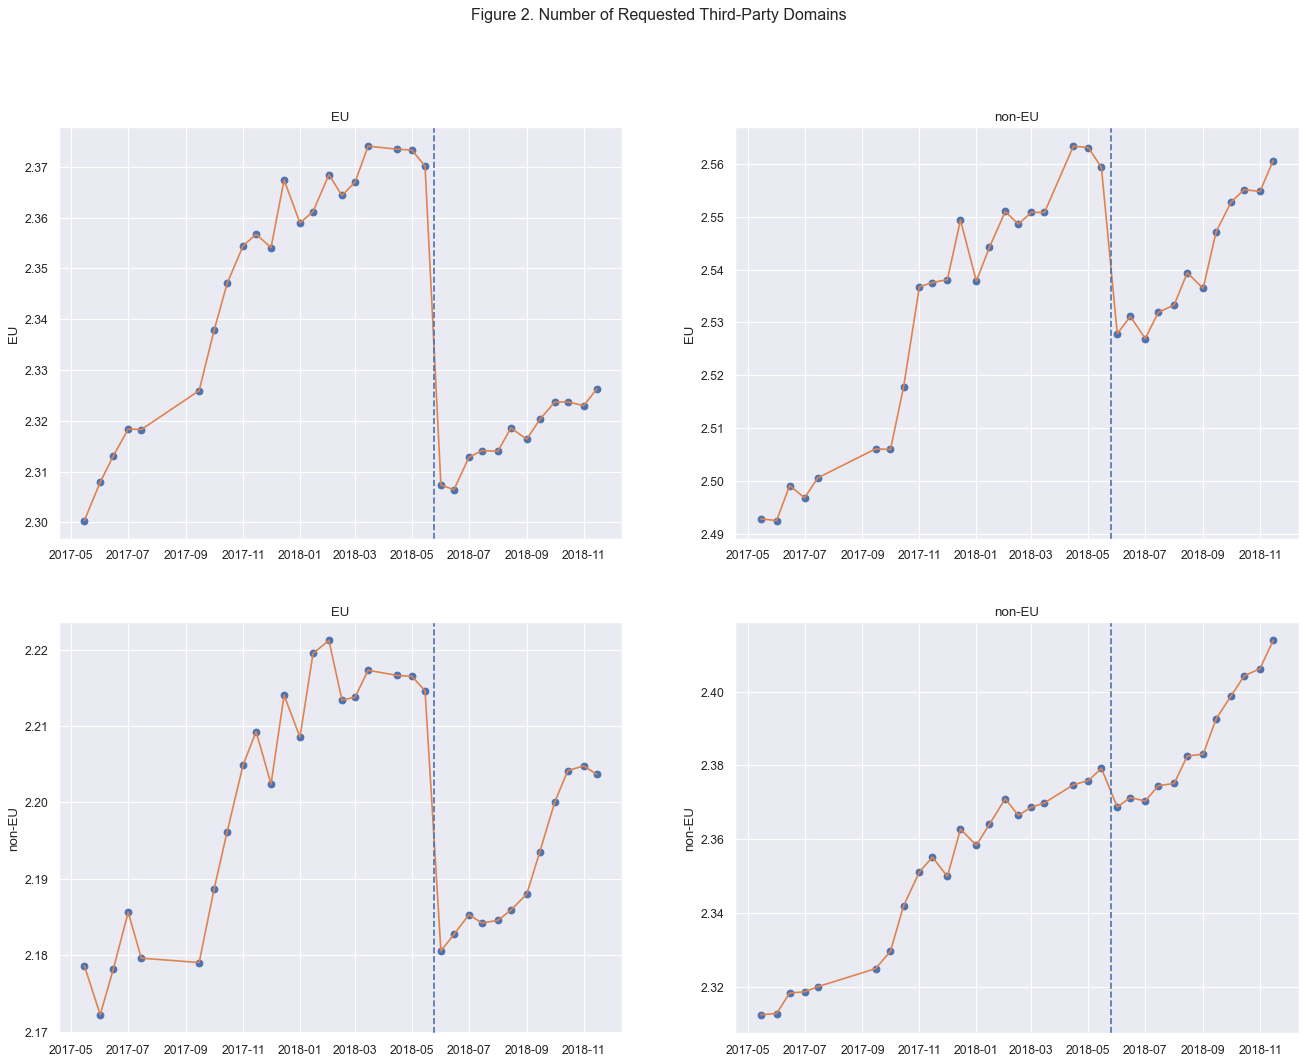

In [19]:
plt.figure(figsize=(20, 15), dpi=80)
plt.subplot(221)
x,y = figure2_variable(data,1)
#plt.ylim(2.36,2.44)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 


plt.subplot(222)
x,y = figure2_variable(data,2)
#plt.ylim(2.26,2.3)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('non-EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 



plt.subplot(223)
x,y = figure2_variable(data,3)
#plt.ylim(2.56,2.64)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 


plt.subplot(224)
x,y = figure2_variable(data,4)
#plt.ylim(2.38,2.48)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('non-EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
plt.suptitle('Figure 2. Number of Requested Third-Party Domains')

### Figure 3 Number of Requested Third-Party Domains That Respond with Cookies

Text(0.5, 0.98, 'Figure 3. Number of Requested Third-Party Domains That Respond with Cookies')

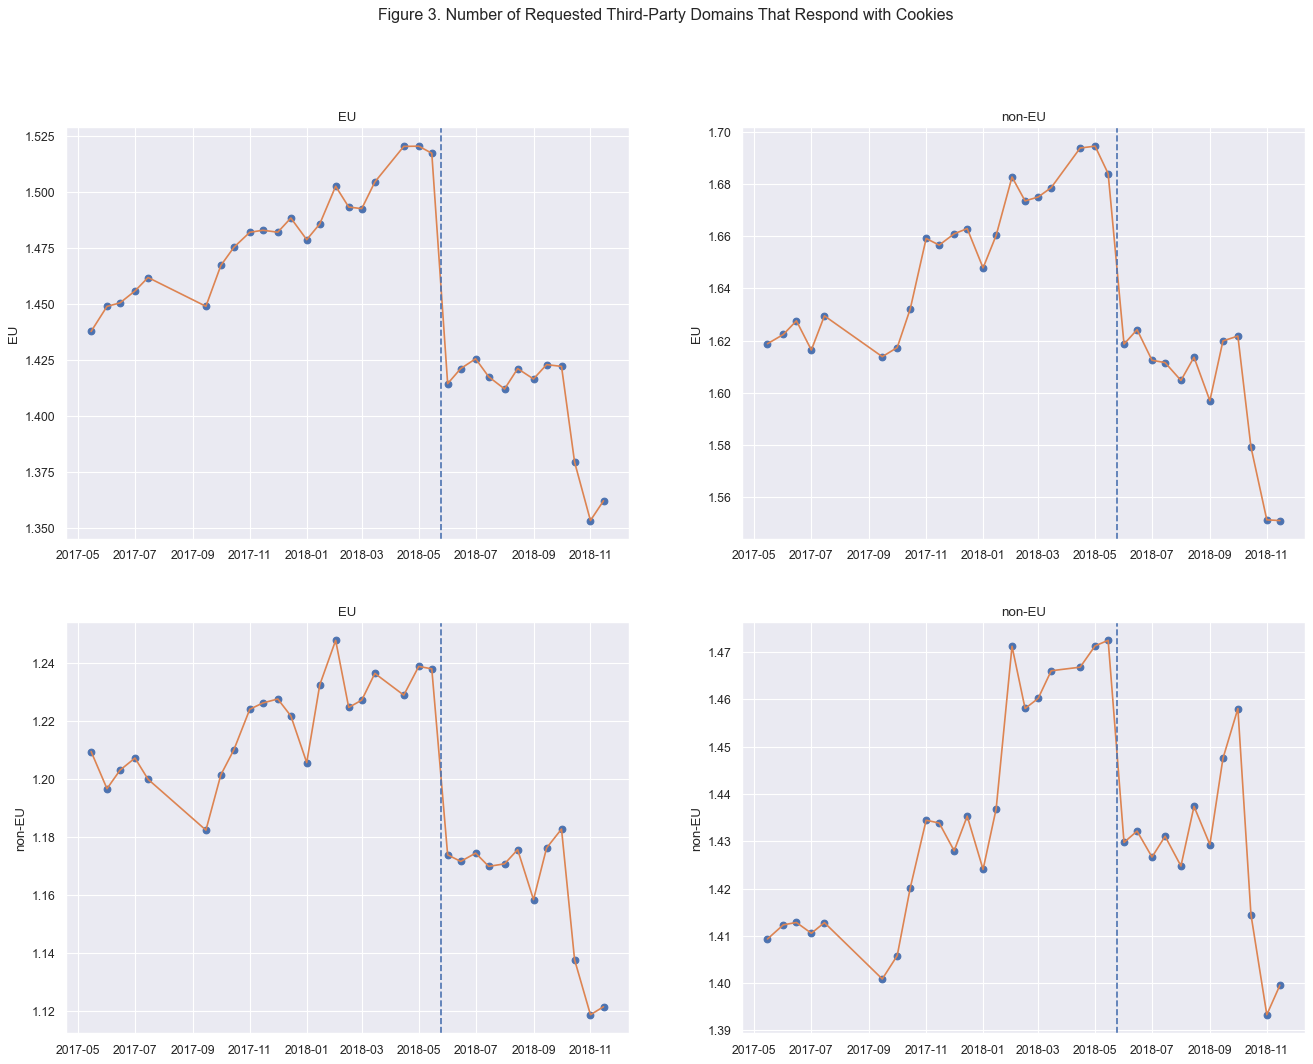

In [22]:
plt.figure(figsize=(20, 15), dpi=80)
plt.subplot(221)
x,y = figure3_variable(data,1)
#plt.ylim(2.36,2.44)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 
plt.subplot(222)
x,y = figure3_variable(data,2)
#plt.ylim(2.26,2.3)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('non-EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 
plt.subplot(223)
x,y = figure3_variable(data,3)
#plt.ylim(2.56,2.64)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 
plt.subplot(224)
x,y = figure3_variable(data,4)
#plt.ylim(2.38,2.48)
plt.plot_date(x,y)
plt.plot(x,y)
plt.title('non-EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
plt.suptitle("Figure 3. Number of Requested Third-Party Domains That Respond with Cookies")

### Figure 4 Requested Third-Party Domains, Facebook vs. non-Facebook

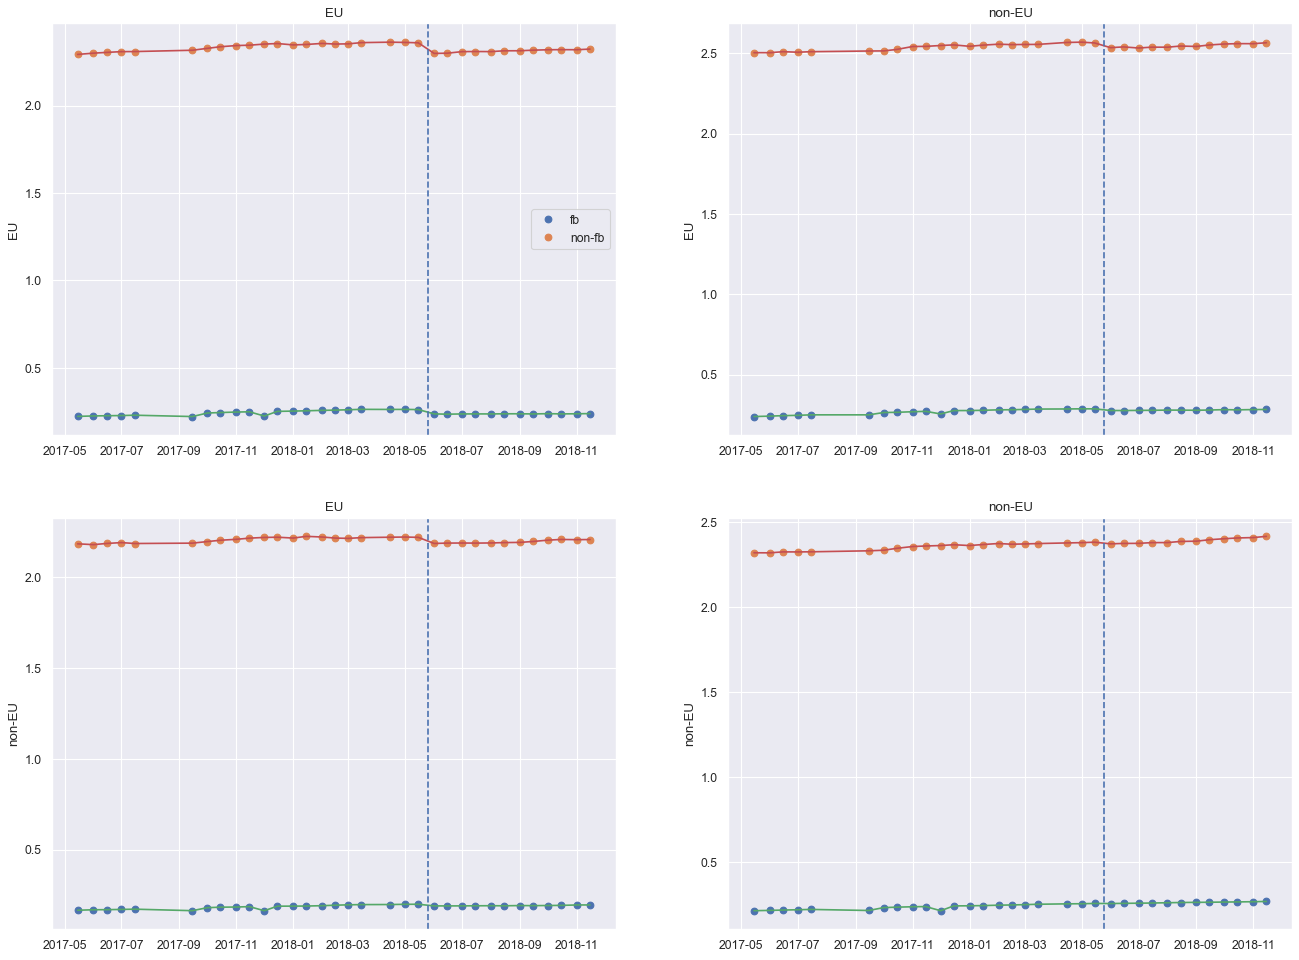

In [35]:
plt.figure(figsize=(20, 15), dpi=80)
plt.subplot(221)
x,y1,y2 = figure4_variable(data,1)
#plt.ylim(2.36,2.44)
plt.plot_date(x,y1,label = 'fb')
plt.plot_date(x,y2, label = 'non-fb')
plt.plot(x,y1)
plt.plot(x,y2)
plt.title('EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
plt.legend()
 
plt.subplot(222)
x,y1,y2 = figure4_variable(data,2)
#plt.ylim(2.26,2.3)
plt.plot_date(x,y1)
plt.plot_date(x,y2)
plt.plot(x,y1)
plt.plot(x,y2)
plt.title('non-EU')
plt.ylabel('EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 
plt.subplot(223)
x,y1,y2 = figure4_variable(data,3)
#plt.ylim(2.56,2.64)
plt.plot_date(x,y1)
plt.plot_date(x,y2)
plt.plot(x,y1)
plt.plot(x,y2)
plt.title('EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
 
plt.subplot(224)
x,y1,y2 = figure4_variable(data,4)
#plt.ylim(2.38,2.48)
plt.plot_date(x,y1)
plt.plot_date(x,y2)
plt.plot(x,y1)
plt.plot(x,y2)
plt.title('non-EU')
plt.ylabel('non-EU')
plt.axvline(x = GDPR, color = 'b', linestyle = '--')
#plt.suptitle("Figure 3. Number of Requested Third-Party Domains That Respond with Cookies")

### - gdpr_vendors.dta - required for tables 6

In [70]:
data_policy = pd.read_stata('/Users/zyy219/Dropbox/Econometric/mksc.2021.1339/data/policies_before.dta')
data = pd.read_stata('/Users/zyy219/Dropbox/Econometric/mksc.2021.1339/data/gdpr_vendors.dta')
data = data[data['exclude']==0]

In [49]:
print(len(data_policy.columns))
print(len(data.columns))

20
11


In [78]:
data_policy.columns

Index(['tracker', 'col_undisclosed', 'col_anonymous', 'col_pseudo', 'col_pii',
       'col_sensitive', 'use_undisclosed', 'use_ad', 'use_analytics',
       'use_custom', 'use_optimization', 'use_tracking', 'shr_undisclosed',
       'shr_aggregate', 'shr_anonymous', 'shr_pseudo', 'shr_pii',
       'shr_sensitive', 'retention', 'retention_months'],
      dtype='object')

In [71]:
D = data.merge(data_policy, on='tracker', how='left')

In [ ]:
np.sum(D['col_undisclosed'])
DD = data_policy.merge(data, on='tracker', how='left')

In [ ]:
print(len(DD))
print(len(D))

In [9]:
print(data_policy.columns)
print(len(data_policy))
#data_policy[['col_pii','shr_pii']]
print(len(data_policy['tracker'].unique()))

Index(['tracker', 'col_undisclosed', 'col_anonymous', 'col_pseudo', 'col_pii',
       'col_sensitive', 'use_undisclosed', 'use_ad', 'use_analytics',
       'use_custom', 'use_optimization', 'use_tracking', 'shr_undisclosed',
       'shr_aggregate', 'shr_anonymous', 'shr_pseudo', 'shr_pii',
       'shr_sensitive', 'retention', 'retention_months'],
      dtype='object')
4867
4867
